<a href="https://colab.research.google.com/github/himanshu-thakur-7/TensorFlow-And-CNN/blob/main/TransferLearningFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer learning Fine Tuning
In the previous notebook, we created transfer learning feature extraction now its time to learn about a new kind of transfer learning: Fine tuning

In [1]:
# check gpu
!nvidia-smi

Sun Jul  4 07:27:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## creating helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-04 07:27:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-04 07:27:36 (93.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
 # Import helper functions we're going to use in this notebook
 from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

We will use pretrained models with tf.keras.applications and apply them to our own problem

In [4]:
# get 10 percent of training data of foood 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-07-04 07:27:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   254MB/s    in 0.6s    

2021-07-04 07:27:39 (254 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [6]:
# create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [7]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size=BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode = "categorical",
                                                                           batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[3.60714302e+01 3.50714302e+01 5.10714302e+01]
   [3.25969391e+01 3.15969391e+01 4.95969391e+01]
   [3.54387741e+01 3.24387741e+01 5.34387741e+01]
   ...
   [1.45015320e+02 1.13872383e+02 1.15005096e+02]
   [1.50148041e+02 1.14387825e+02 1.19459251e+02]
   [1.54331451e+02 1.14974312e+02 1.21045738e+02]]

  [[3.25510216e+01 3.15510197e+01 4.75510216e+01]
   [3.47857132e+01 3.37857132e+01 5.17857132e+01]
   [3.52857132e+01 3.22857132e+01 5.32857132e+01]
   ...
   [1.39040848e+02 1.08484673e+02 1.05341835e+02]
   [1.39285721e+02 1.05285728e+02 1.03500015e+02]
   [1.47658325e+02 1.11658325e+02 1.11801186e+02]]

  [[2.89489784e+01 2.79489784e+01 4.39489784e+01]
   [2.78010197e+01 2.68010197e+01 4.28010178e+01]
   [2.59540806e+01 2.29540806e+01 4.15255089e+01]
   ...
   [1.37714279e+02 1.07974464e+02 9.94999771e+01]
   [1.45142746e+02 1.12785606e+02 1.05015175e+02]
   [1.32091827e+02 9.97346878e+01 9.14540176e+01]]

  ...

  [[2.64290047e+00 9.07142830e+00 2.80619979e-01]
   [8

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API
The Sequential API is straight-forward, it runs our layers in sequential order

But the functional API gives us more flexibility with our models.


In [11]:
# create base model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3),name="input_layer")

# 4. If using a model like Resnet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5 pass the inputs to base model
x = base_model(inputs)
print(f"shape after passing {x.shape}")

# 6 average pool the outputs of the base model (aggregate all the most important info, reduce num of comparisons)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"shape after GlobalAveragePooling2D: {x.shape}")

# 7 create the output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8 Combine inputs with outputs into a model
model_0 = tf.keras.Model(inputs,outputs) 

# 9 Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])


# 10. fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data = test_data_10_percent,
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback("teransfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

16711680/16705208 [==============================] - 0s 0us/step
shape after passing (None, 7, 7, 1280)
shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: teransfer_learning/10_percent_feature_extraction/20210704-072749
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 42s 301ms/step - loss: 1.9190 - accuracy: 0.3867 - val_loss: 1.4013 - val_accuracy: 0.6908
Epoch 2/5
24/24 [==============================] - 5s 196ms/step - loss: 1.1638 - accuracy: 0.7573 - val_loss: 0.9577 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - 5s 196ms/step - loss: 0.8413 - accuracy: 0.8227 - val_loss: 0.7980 - val_accuracy: 0.8043
Epoch 4/5
24/24 [==============================] - 5s 196ms/step - loss: 0.6893 - accuracy: 0.8480 - val_loss: 0.6787 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 5s 197ms/step - loss: 0.5953 - accuracy: 0.8707 - val_loss: 0.6103 - val_accuracy: 0.8503


In [12]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 9s 111ms/step - loss: 0.6153 - accuracy: 0.8432


[0.6153345108032227, 0.8432000279426575]

In [13]:
# check the layers in base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
# summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [15]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


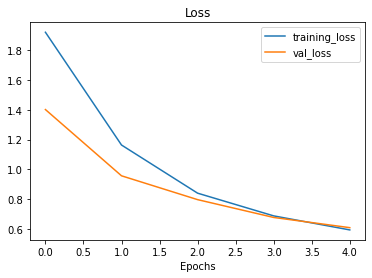

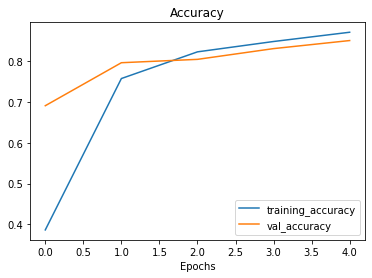

In [16]:
# check out our model;s training curve
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model


Let's demonstrate the global Average Pooling 2D layer..

we have a tensor after our model goes through base_model of shape (None,7,7,1280).
But then when it passes through GlobalAveragePooling2D, it turns into (None,1280).
Lets use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [17]:
# Define the input shape
input_shape = (1,2,2,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# pass the random tensor to global Average Pooling 2D layer
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooling_tensor}\n")

#check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooling_tensor.shape}") 

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]]

  [[-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]]]

2D global average pooled random tensor:
 [[-0.3371175  -1.0493976   0.17876767]]

Shape of input tensor: (1, 2, 2, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [18]:
# Replicating globalAverage Pool2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.3371175 , -1.0493976 ,  0.17876767]], dtype=float32)>

In [19]:
global_max_pooling_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooling_tensor}\n")


2D global max pooled random tensor:
 [[0.3274685 0.539707  1.6994323]]



 **Note**: One of the reasons feature extraction transfer learning is named how it is is because what often
 happens is pretrained model outputs a feature vector a tensor of numbers which represents the leaned representation of the model 
 on a particular sample ,in our case this is the output of tf.keras.layers.GlobalAveragePooling2D layer which then can be used to extract 
 patterns out of own specific problem

Running a series of transfer learning experiments

We've seen incredible results transfer learning can get with only 10% of training data,
but how does it go with 1% of the training data... how about we setup a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with 
data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of training data with data augmentation
3. `model_3` - use fine tuning transfer learning on 10% of training data with data augmentation.
4. `model_4` - use fine tuning transfer learning on 100% of the training data with data augmentation.

** same test set will be used for all experiments .. this ensures consistency across evaluation metrics.


In [20]:
# download and unzip data - preprocessed from food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2021-07-04 07:29:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.240, 142.250.65.80, 142.250.188.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   251MB/s    in 0.5s    

2021-07-04 07:29:03 (251 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
# # create training training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [22]:
# how many images are we working with ?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'

In [23]:
# set up data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE
                                                                            )
test_data  = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode = "categorical",
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## adding data augmentation directly into the model
To add data augmentation right into our model we can use the layer inside:
* tf.keras.layers.experimental.preprocessing().

Benefits:

* Preprocessing of images happens on the GPU so is faster than CPU
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere.


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# create data augmentation stage with horizontal flipping,rotations, zooms etc
data_augmentation = keras.Sequential([
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.2),
      preprocessing.RandomZoom(0.2),
      preprocessing.RandomHeight(0.2),
      preprocessing.RandomWidth(0.2),
      # preprocessing.Rescale(1./255) # keep for models like ResNet50V2
],name = "data_augmentation")


# visualizing effect of augmentation of our data


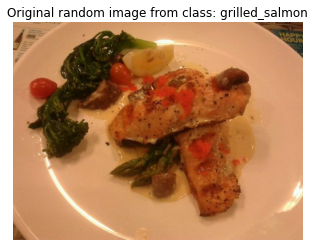

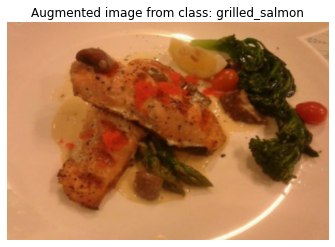

In [25]:
# view a random image and compare to its augmented image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img/255.)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);


# now read and plot augmented image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()

plt.title(f"Augmented image from class: {target_class}")
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.axis(False);
# print(img)

# Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation.

In [26]:
# set up input shape and base model , freezing base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create input layer
inputs = layers.Input(shape=input_shape,name = "input_layer")

# add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# give basemodel the augmented inputs and dont train it
x = base_model(x,training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dense layer as the output
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

# compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics =  ["accuracy"])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # track model training logs
                                callbacks  = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name = "1_percent_data_aug")]
                                )

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210704-072908


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
3/3 [==============================] - 11s 3s/step - loss: 2.3966 - accuracy: 0.1143 - val_loss: 2.2574 - val_accuracy: 0.1299
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1570 - accuracy: 0.0857 - val_loss: 2.1396 - val_accuracy: 0.2286
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9942 - accuracy: 0.3143 - val_loss: 2.0349 - val_accuracy: 0.2928
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8230 - accuracy: 0.4857 - val_loss: 1.9361 - val_accuracy: 0.3635
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 1.6644 - accuracy: 0.6286 - val_loss: 1.8405 - val_accuracy: 0.4062


In [27]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [28]:
# Evaluate on full test data set
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 9s 106ms/step - loss: 1.8224 - accuracy: 0.4412


[1.8224353790283203, 0.44119998812675476]

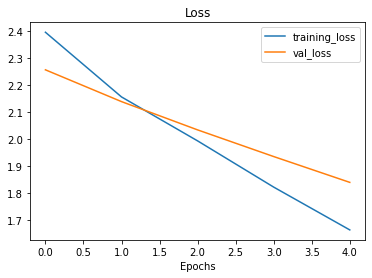

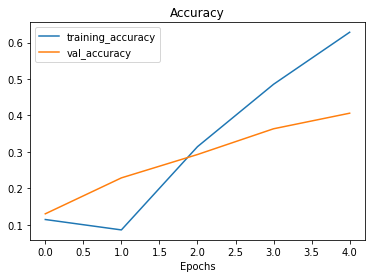

In [29]:
plot_loss_curves(history_1_percent)

## Model 2 : feature Extraction transfer learning model with 10% of data and data augmentation.


In [30]:
train_dir_10_percent  = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"
 
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [31]:
import tensorflow as tf 
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size = IMG_SIZE)

train_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode="categorical",
                                                                  image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
# data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1/255.) to be used with model like Resnet50V2
], name = "data_augmentation")


In [33]:

# set up input shape and base model (frozen backbone)
input_shape = (224,224,3)
base_model  = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create input layer
inputs = layers.Input(shape = input_shape,name = "input_layer")

# add in data augmentation sequential model as layer
x  = data_augmentation(inputs)

# give base model augmented inputs and dont train it
x = base_model(x,training = False)

# pool output features of base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling")(x)

# put a dense layer as output layer
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# make a model using input and output 
model_2 = keras.Model(inputs,outputs)

# compile the model 
model_2.compile(optimizer=tf.keras.optimizers.Adam(),loss = "categorical_crossentropy",metrics = ["accuracy"])



# Creating a model checkpoint callback
The modelChecpoint Callback itermediately saves our model (the full model or just the weights ) during training . This is useful so we can come and start where we left off.

In [34]:
# set check point path 
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# create a ModelCheckPoint call back that saves model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1
                                                         )

In [35]:
# fit the model
history_model_2  = model_2.fit(train_data_10_percent,
                               epochs = 5,
                               steps_per_epoch = len(train_data_10_percent),
                               validation_data = test_data,
                               validation_steps = int(0.25*len(test_data)),
                               callbacks = [create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_data_aug"),checkpoint_callback]
                               )

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210704-072953
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 19s 612ms/step - loss: 1.9821 - accuracy: 0.3347 - val_loss: 1.5158 - val_accuracy: 0.6365

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 11s 458ms/step - loss: 1.3616 - accuracy: 0.6600 - val_loss: 1.0754 - val_accuracy: 0.7632

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 10s 409ms/step - loss: 1.0637 - accuracy: 0.7307 - val_loss: 0.8704 - val_accuracy: 0.7977

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 10s 407ms/step - loss: 0.8884 - accuracy: 0.7747 - val_loss: 0.7579 - val_accuracy: 0.8076

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 10s 409ms/step - loss: 0.8142 - accuracy: 0.7947 - val_

In [36]:
# evaluate the model 
model_2.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.6929 - accuracy: 0.8180


[0.6928820610046387, 0.8180000185966492]

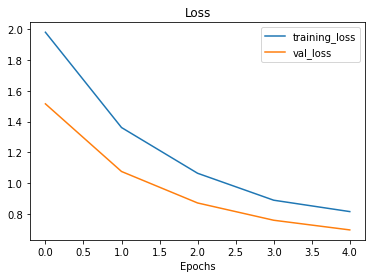

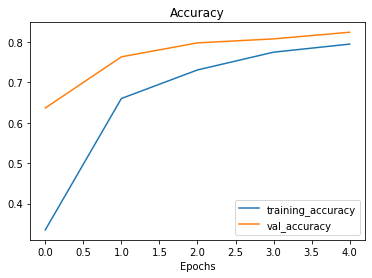

In [37]:
# plot the loss curves
plot_loss_curves(history_model_2)

# Model 3 : Fine tuning an exisiting model on 10% of the data


> **Note**: Fine tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data. 

In [38]:
# layers in loaded model
model_2.layers

In [39]:
# are these layers trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7efe30206310> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7efe301faa10> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7efe30731a10> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7efe30206210> True
<tensorflow.python.keras.layers.core.Dense object at 0x7efe305fdad0> True


In [40]:
# layers in efficientnetB0 and are they trainable?
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [41]:
# How many trainable variables in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [42]:
# To begin fine-tuning, lets start by setting the last 10 layers of our base_model.trainable = true
base_model.trainable = True

# freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine tuning lower learning rate by 10x
                metrics = ["accuracy"]
                )


In [43]:
# How many trainable variables in our base model
print(len(model_2.layers[2].trainable_variables))

10


In [44]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [45]:
# fine tune for another 5 epochs 
fine_tune_epochs = 10

# refit the model (same as model 2 with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25*(len(test_data))),
                                               initial_epoch = history_model_2.epoch[-1],  # start training from last trained epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")]
                                               )

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210704-073125
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 19s 516ms/step - loss: 0.6501 - accuracy: 0.8160 - val_loss: 0.5610 - val_accuracy: 0.8191
Epoch 6/10
24/24 [==============================] - 10s 395ms/step - loss: 0.5519 - accuracy: 0.8320 - val_loss: 0.5443 - val_accuracy: 0.8224
Epoch 7/10
24/24 [==============================] - 9s 384ms/step - loss: 0.5036 - accuracy: 0.8427 - val_loss: 0.5040 - val_accuracy: 0.8322
Epoch 8/10
24/24 [==============================] - 9s 380ms/step - loss: 0.4518 - accuracy: 0.8493 - val_loss: 0.4979 - val_accuracy: 0.8224
Epoch 9/10
24/24 [==============================] - 9s 376ms/step - loss: 0.4082 - accuracy: 0.8787 - val_loss: 0.4738 - val_accuracy: 0.8339
Epoch 10/10
24/24 [==============================] - 9s 361ms/step - loss: 0.3612 - accuracy: 0.8960 - val_loss: 0.4519 - val_accuracy: 0.8421


In [46]:
# Evaluate the fine tuned model (model 2 finetuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.4811 - accuracy: 0.8348


In [47]:
results_fine_tune_10_percent

[0.48113346099853516, 0.8348000049591064]

In [48]:
results_1_percent_data_aug

[1.8224353790283203, 0.44119998812675476]

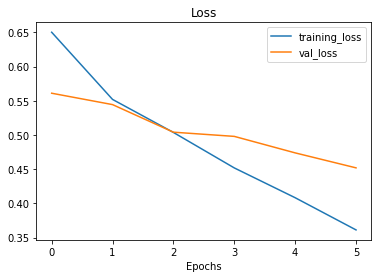

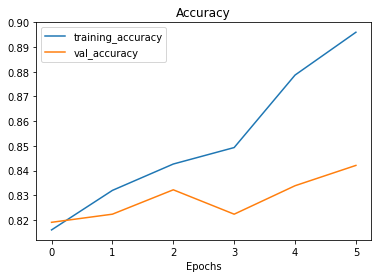

In [49]:
# check out loss curves
plot_loss_curves(history_fine_10_percent_data_aug)

The plot loss curves function works great with models which have only been fit once , however we want to compare one series of runnning fit with another (eg. before and after fine tuning)


In [50]:
# lets compare a function to compare training histories 
def compare_historys(original_history,new_history,initial_epochs=5):
  """
  Compare two tensorflow history objects

  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # combine original history
  total_acc = acc+new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc+new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc,label = "Val Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and validation Accuracy")
   
  # make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss,label = "Val Loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and validation Accuracy")
  


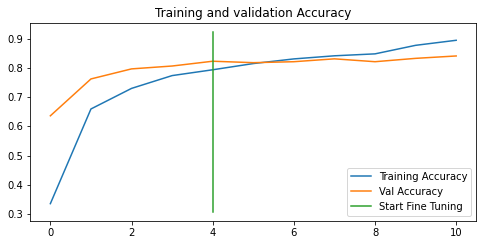

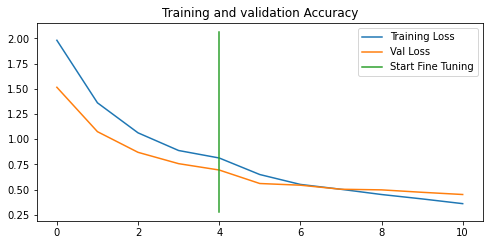

In [51]:
compare_historys(history_model_2,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

##Model 4 : Fine tuning existing model on 100% data


In [52]:
# download and unzipn 10 classes of Fodd 101 with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-07-04 07:32:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   275MB/s    in 1.8s    

2021-07-04 07:32:52 (275 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [53]:
# setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir_all_data = "10_food_classes_all_data/test"


In [54]:
# How many images are we working with now ?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 

In [55]:
# set up data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(test_dir_all_data,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE
                                                                                )

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [56]:
# Evaluate model 2
model_2.evaluate(test_data_10_classes_full)

79/79 [==============================] - 9s 107ms/step - loss: 0.4811 - accuracy: 0.8348


[0.4811335802078247, 0.8348000049591064]

To train a fine-tuning model (model_4) we need  to revert model_2 back to its feature extraction weights.

In [57]:
# load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine tuned
model_2.load_weights(checkpoint_path)

In [58]:
# lets evaluate model 2 now
model_2.evaluate(test_data_10_classes_full)

79/79 [==============================] - 9s 108ms/step - loss: 0.6929 - accuracy: 0.8180


[0.692882239818573, 0.8180000185966492]

All we have done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using ModelCheckpoint callback.
2. Fine Tuned the same model on the same 10% of the data for a further 5 epochs with top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step1 to do the same steps as step2  except this time we're going to use all of the data (model_4).

In [59]:
# check which layers are tunable in whole model
for layer_number,layer in enumerate(model_2.layers ):
  print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling True
4 output_layer True


In [61]:
# let's see what layers in efficentnetB0 are trainable
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [62]:
# compile 
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [65]:
# Continue to train and fine tune model on 100% data
initial_epoch = 5
fine_tune_epochs = initial_epoch + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data_10_classes_full,
                                           validation_steps= int (0.25*len(test_data)),
                                           initial_epoch = history_model_2.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210704-080757
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 51s 196ms/step - loss: 0.7251 - accuracy: 0.7679 - val_loss: 0.3777 - val_accuracy: 0.8717
Epoch 6/10
235/235 [==============================] - 60s 252ms/step - loss: 0.5997 - accuracy: 0.8069 - val_loss: 0.3030 - val_accuracy: 0.9013
Epoch 7/10
235/235 [==============================] - 53s 223ms/step - loss: 0.5336 - accuracy: 0.8247 - val_loss: 0.3135 - val_accuracy: 0.9030
Epoch 8/10
235/235 [==============================] - 49s 205ms/step - loss: 0.4769 - accuracy: 0.8477 - val_loss: 0.2542 - val_accuracy: 0.9128
Epoch 9/10
235/235 [==============================] - 47s 200ms/step - loss: 0.4467 - accuracy: 0.8532 - val_loss: 0.2790 - val_accuracy: 0.9030
Epoch 10/10
235/235 [==============================] - 45s 188ms/step - loss: 0.4194 - accuracy: 0.8592 - val_loss: 0.2534 - val_accuracy: 0.9260


In [66]:
# lets evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data_10_classes_full)
results_fine_tune_full_data

79/79 [==============================] - 9s 105ms/step - loss: 0.3030 - accuracy: 0.9028


[0.30300453305244446, 0.9028000235557556]

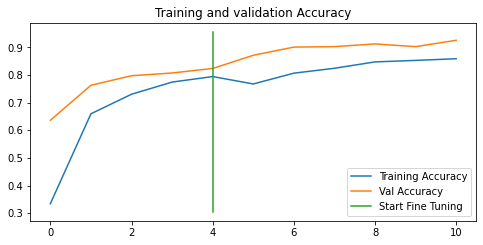

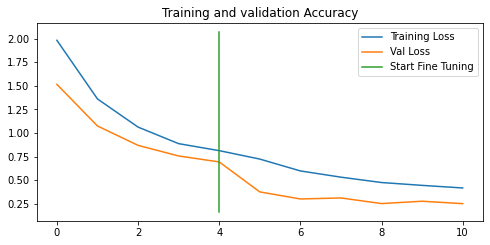

In [68]:
# how did the fine-tuning go with more data?
compare_historys(original_history=history_model_2,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment on TensorBoard


In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A Series of different transfer Learning Experiments with varying amounts of data and fine tuning" \
  --one_shot # exits the uploader after uploading

Tensorboard Experiments @  https://tensorboard.dev/experiment/HVRZpFZzTaaEqIq2D4AoEQ/